<a href="https://colab.research.google.com/github/Christian-Stefan/Team-Internship/blob/Chris/PipelinePreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# !pip install pydicom

import numpy as np
import matplotlib.pyplot as plt
import json, glob, re, os, pydicom
from skimage.draw import polygon
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from scipy.ndimage import binary_fill_holes,label,binary_dilation,binary_erosion, binary_closing
from ipywidgets import interact

Loading data from.../content/drive/MyDrive/TeamInternship/Input_Data


<ipython-input-125-babdc5761151>:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Number of CTs preprocessed: 5
Number of slices in the first CTs: 22


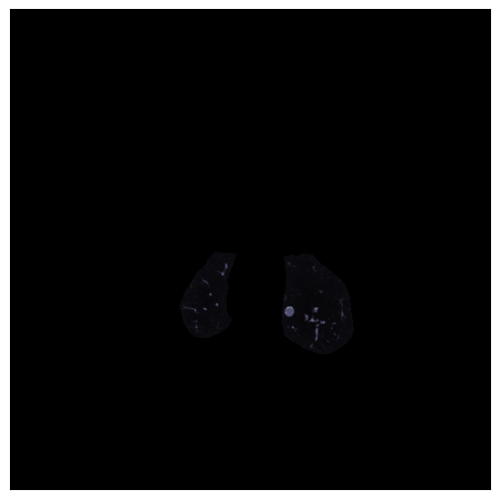

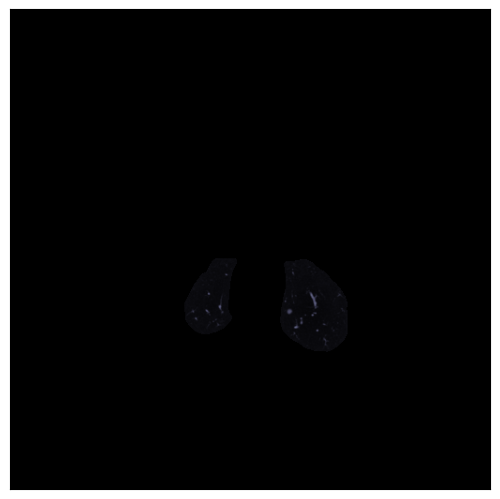

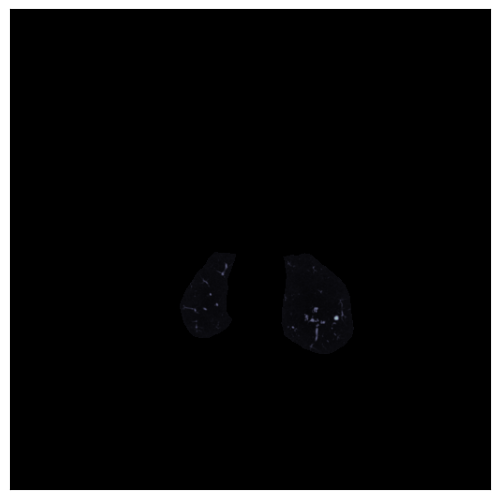

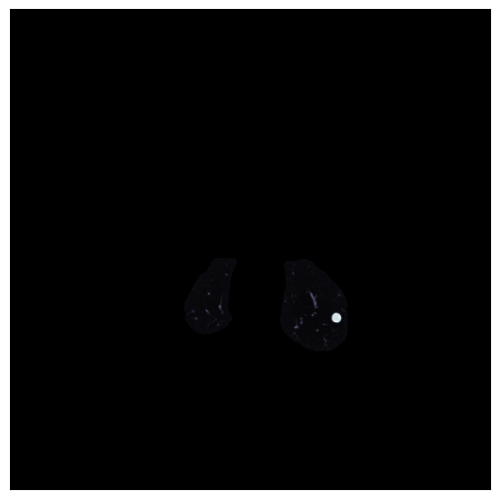

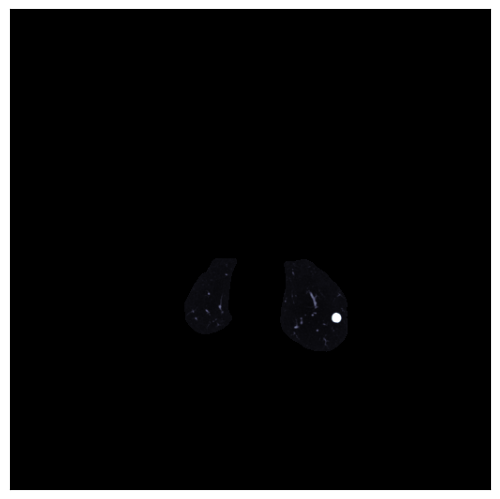

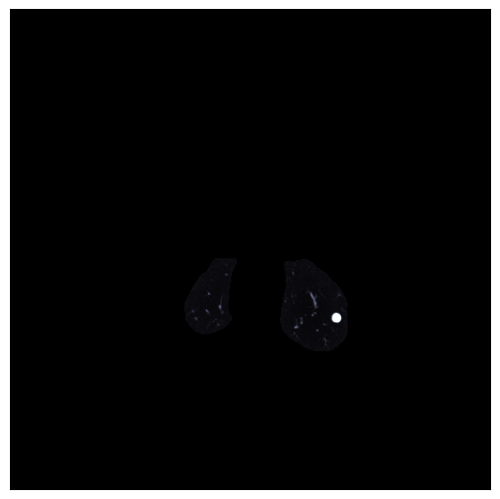

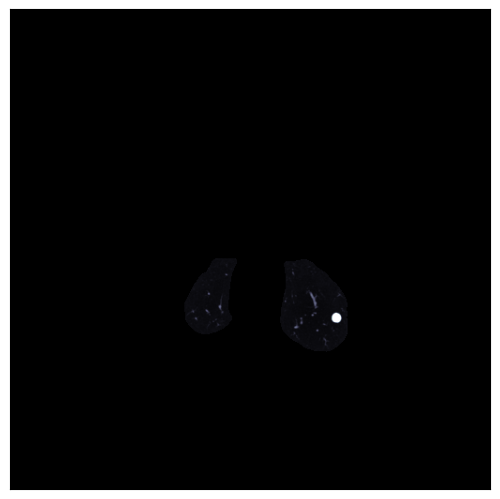

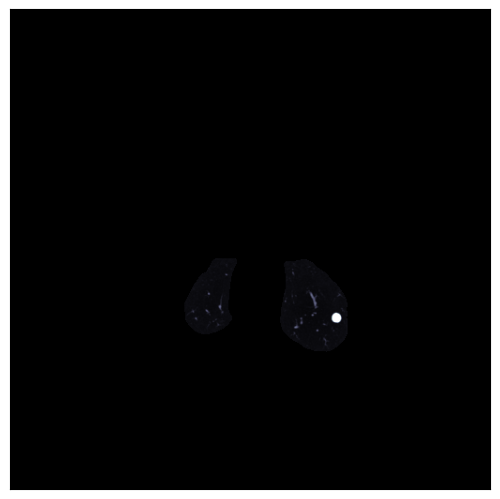

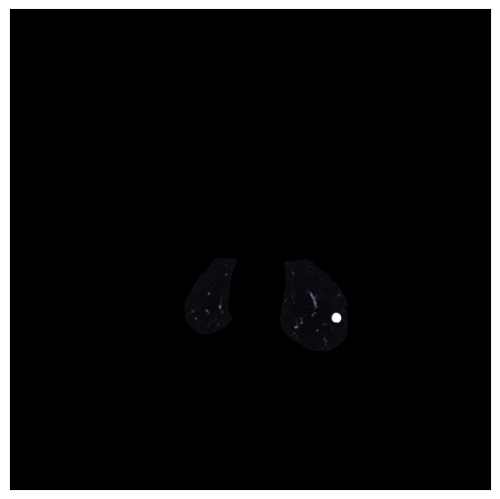

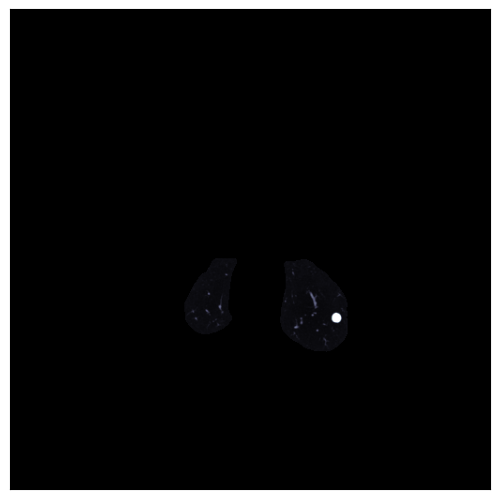

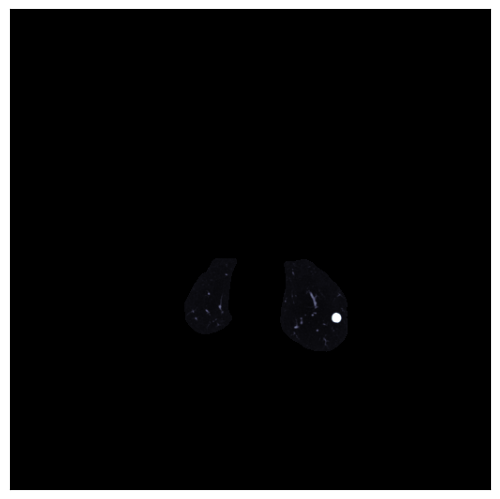

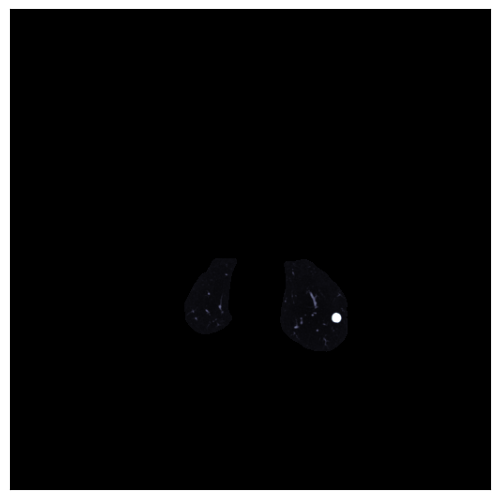

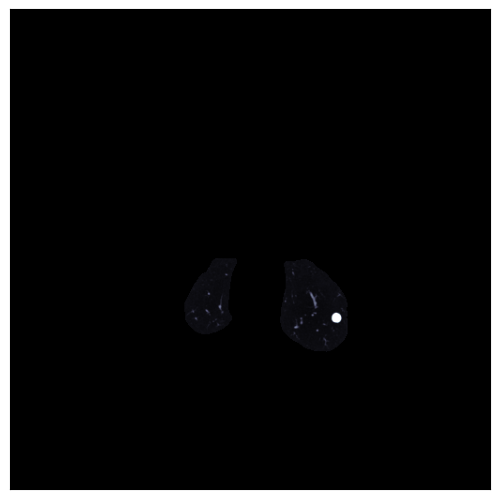

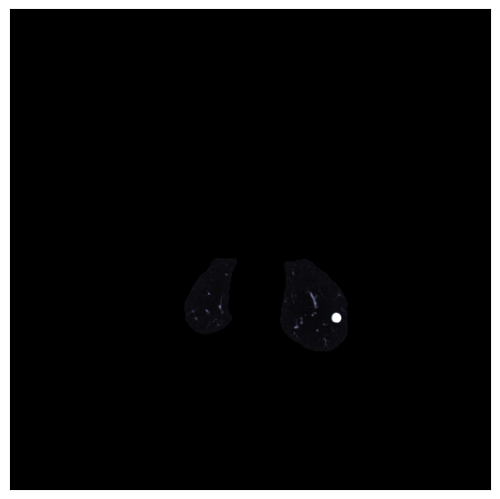

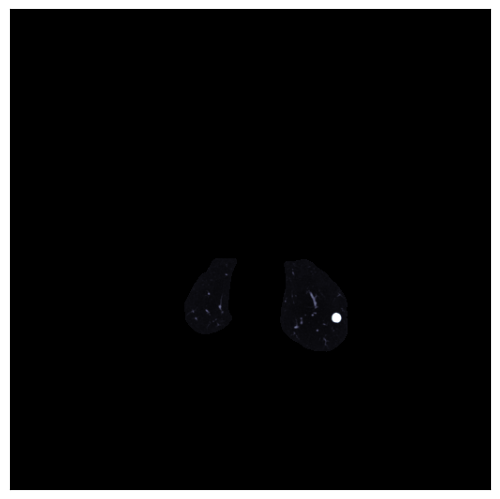

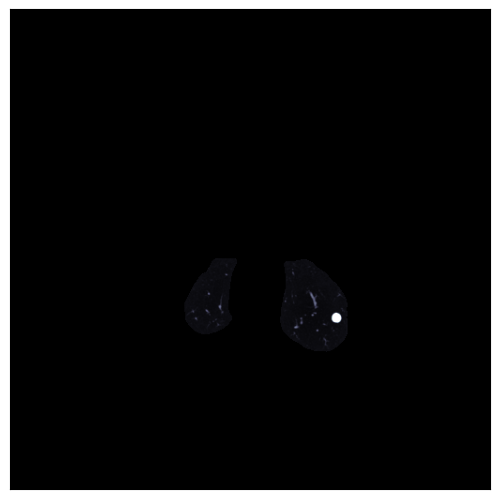

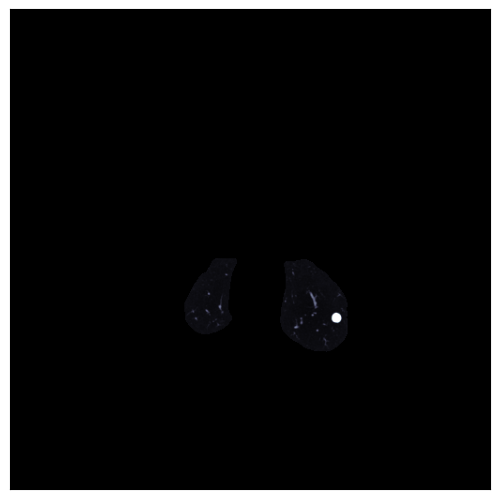

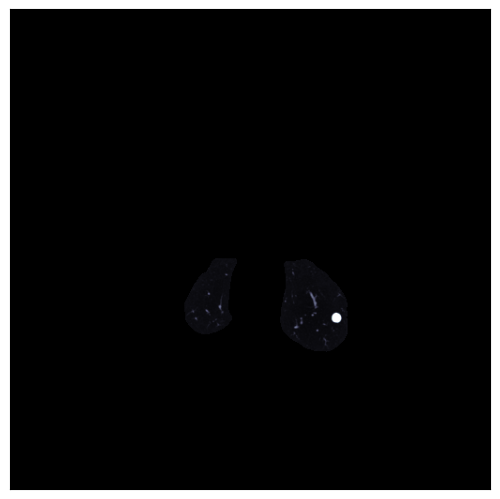

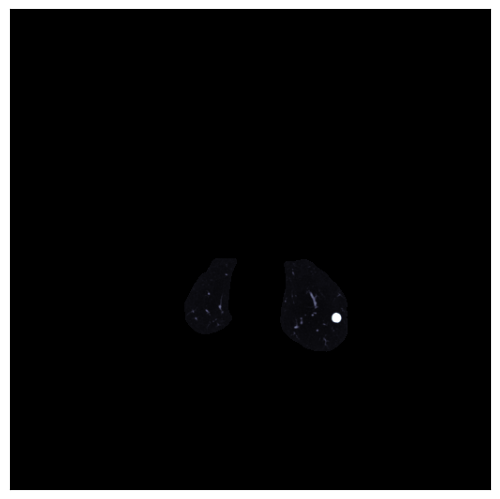

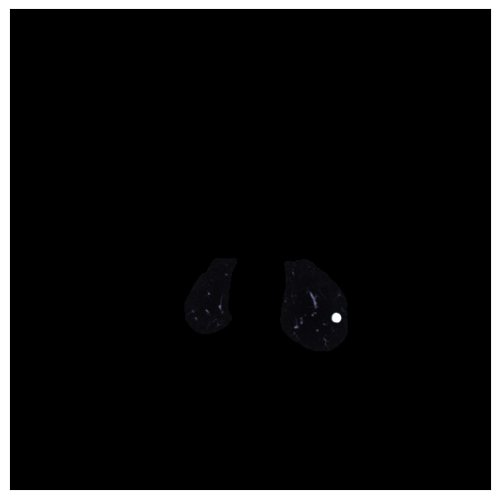

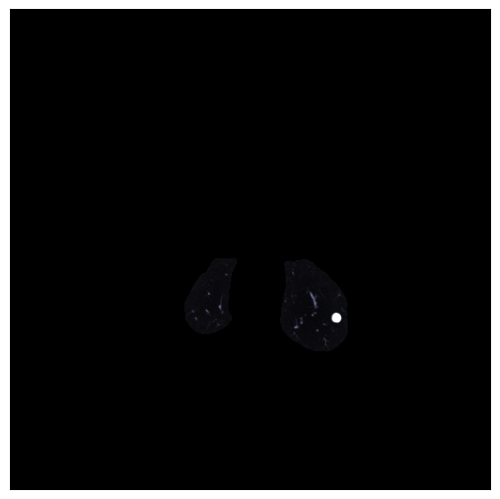

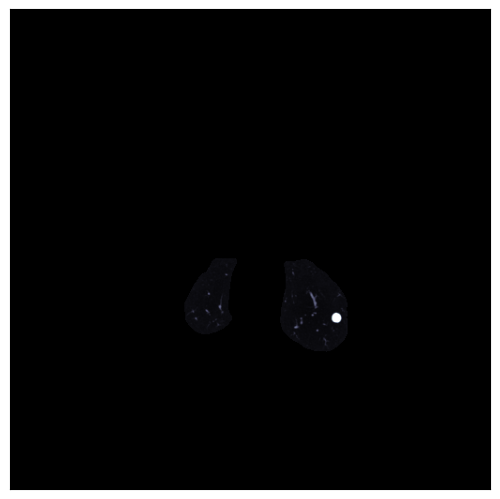

In [125]:
class Preprocessing:

  def __init__(self,
               Output_path:str,
               Root_path:str,
               Json_path:str = None):

    self.Json_path = Json_path
    self.Output_path = Output_path
    self.Root_path = Root_path

  def get_slice_and_coordnates_Paths(self,
                                     root_path:str=None):
      ct_collections = []

      if root_path == None:
        root_path = self.Root_path
      else:
        pass

      print("Loading data from...{}".format(root_path))
      for dirpath, dirnames, filenames in os.walk(root_path):
          folder_name = os.path.basename(dirpath)
          if "-NA-" in folder_name:
              # print("Folder name:", folder_name)

              # Collect and sort full paths to .dcm files
              dcm_files = sorted(
                  [os.path.join(dirpath, f) for f in filenames if f.lower().endswith('.dcm')]
              )

              # Identify the .json file
              json_files = [f for f in filenames if f.lower().endswith('.json')]
              json_file = json_files[0] if json_files else None

              if dcm_files and json_file:
                  json_path = os.path.join(dirpath, json_file)

                  # Load and parse JSON to extract annotations
                  with open(json_path, 'r') as f:
                      d = json.load(f)

                  slice_coords = []
                  for annotation in d.get("annotation", []):
                      slice_key = next(iter(annotation))
                      coords = annotation[slice_key]['segmentation'][0]
                      slice_coords.append(coords)

                  # Full list of paths: DICOMs + JSON
                  full_sequence = dcm_files + [json_path]

                  # Append both: [paths, coordinates]
                  ct_collections.append([full_sequence, slice_coords])

      return ct_collections

  def preprocess_Data(self,
                data:list,
                save_base_path:str = None,
                plot:bool = True,
                save:bool = False,
                segment:bool = False,
                output:bool = False):

      '''
          slice_paths: relative paths for each slice in a scan containing a nodule
          slice_coords: coordinates of nodule for each slice in a scan
          plot: want to plot the slices?
          save: want to save the slices?
          segment: want to output only nodule (so segmented) or the entire lungs?
          output: want to return the output?

      '''
      # ---- Containers Definition ----- # Starts
      slices_coords:list = [] # Container with nodule cordinates
      slices_paths:list = [] # Container with nodule paths
      slices_z:list = [] # Deepness of each nodule belonging to a given CT
      slies_deepness:list = [] # Deepness of each CT
      slices_deepness:list = [len(data[deep][0]) for deep in range(len(data))] # Deepness of each CT through list comprehension
      processed_out:list = []
      index_coords:int = 0
      # ---- Containers Definition ----- # Ends

      # 1. Extracting relaive paths and nodule coordinates
      for file in data:
        if 'segmentation' in str(file[:][0]): # Sorting out coordinates and identifying all the paths
          json_file = file[:][0][(len(file[:][0])-1)] # 1.1 Selecting the very last element in the subdirectory which usually is .json
          with open(json_file,'r' ) as file_json:
            json_segmentation = json.load(file_json)
            for z, slices in enumerate(json_segmentation['annotation']):# 3.1. Extracting the number of slices (e.g., z axis)
              for slice in slices: # 3.2. Using the number indicating the exact slice to access the (x,y) coordinates
                # 2. After slices of interest have been localized dcmread is possible
                slices_coords.append([slices[slice]['segmentation'][0]]) # Appending Slices coordinates
                if len(str(slice)) == 2:
                  expected_filename = f"1-{int(slice):04d}.dcm"
                  for slice_path in file[:][0]:
                    if expected_filename in slice_path:
                      slices_paths.append(slice_path) # Appending Slice Paths
            slices_z.append([z])
        # -- Baseline 1 -> slice_paths, slices_coords

      processed_out_temporary:list = []
      # 3. Parse .dicom dataset
      for ct in range(len(data)):
        ct_overall_deepness = len(data[ct][0]) # Parse the slice sequence of all CTs

        # ct_nodule_deepness = slices_z[ct] # Retrieving the nodule deepness/height
        # ct_nodule_slices = slices_coords[ct] # Optional generators
        # print("Processing CT:{}, which has the deepness of {} slices and {} containing nodules".format(data[ct][0],
        #                                                                                                ct_overall_deepness, ct_nodule_deepness))

        # 3.1. Read with .dcmread each slice
        for slice_index in enumerate(range(slices_z[ct][0]+1)):
          path = slices_paths[0]
          dicom_data = pydicom.dcmread(path) # Reading slice by slice a given CT
          IMAGE_RAW = dicom_data.pixel_array # Raw image
          IMAGE_NOT_RAW = dicom_data.pixel_array.astype(np.float32) # Not-raw image
          slices_paths.pop(0) # Removing the slice path from slices paths

          # 4. Segment lung
          IMAGE_LUNG = self.segment_lungs(IMAGE_NOT_RAW)

          if sum(sum(IMAGE_LUNG))>5000000:
            image_out = self.segment_lungs(IMAGE_NOT_RAW,
                                            threshold_non_black = 200,
                                            threshold_lung_mult = 0.4)
          # 5. Segment nodule
          if segment:
            image_out = self.segment_nodule(IMAGE_NOT_RAW,
                                       IMAGE_LUNG,
                                       slice=slices_coords[index_coords][0])
            index_coords+=1 # Update nodule coordinate index

          processed_out_temporary.append(image_out)

          if plot:
            fig, ax = plt.subplots()

            ax.imshow(image_out, cmap=plt.cm.bone, vmin=IMAGE_RAW.min(), vmax=IMAGE_RAW.max())
            #plt.title("Extracted Region from DICOM")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_position([0, 0, 1, 1])

        processed_out.append(processed_out_temporary) # Adding processed CTs in processed_out container

      print(f"Number of CTs preprocessed: {len(processed_out)}\n"
      f"Number of slices in the first CTs: {len(processed_out[1])}")

  def segment_lungs(self,
                    image,
                    threshold_non_black = 100,
                    threshold_lung_mult = 1):
    # Remove completely black background
    non_black_mask = image > threshold_non_black  # Ignore pure black regions outside scan
    scan_region = binary_fill_holes(non_black_mask)  # Fill holes in the scan area

    # Apply thresholding **only inside the scan region**
    thresh = threshold_otsu(image[scan_region])  # Compute threshold ignoring black border
    lung_mask = (image < thresh*threshold_lung_mult) & scan_region  # Select dark regions **inside the scan**

    # Morphological operations to clean up
    lung_mask = binary_dilation(lung_mask, iterations=3) # add back in some of the area around the lungs
    lung_mask = binary_fill_holes(lung_mask)  # Fill small holes, helps if nodule was close to lung wall

    # keep the two largest regions (lungs)
    labeled_mask, num_features = label(lung_mask)
    unique, counts = np.unique(labeled_mask, return_counts=True)
    sorted_labels = sorted(zip(unique[1:], counts[1:]), key=lambda x: -x[1])[:2]  # Top 2 largest
    lung_mask = np.isin(labeled_mask, [s[0] for s in sorted_labels])  # Keep only lungs

    lung_mask = binary_erosion(lung_mask, disk(4)) # remove lung wall

    # final mask
    lungs_only = np.zeros_like(image)
    lungs_only[lung_mask] = image[lung_mask]

    return lungs_only

  def segment_nodule(self,
                     image,
                     lungs_only,
                     slice):

    height, width = image.shape

    x_coords = slice[::2]
    y_coords = slice[1::2]

    x_coords_new = (np.array(x_coords) * width).astype(int)
    y_coords_new = (np.array(y_coords) * height).astype(int)


    mask = np.zeros_like(image, dtype=bool)

    # Get polygon fill area
    rr, cc = polygon(y_coords_new, x_coords_new, mask.shape)
    mask[rr, cc] = True  # Fill the polygon

    # Fill any holes inside the polygon
    mask = binary_fill_holes(mask)

    # Expand mask by 4 pixels
    mask = binary_dilation(mask, iterations=3)


    # Create the masked image
    masked_image = np.zeros_like(lungs_only)
    masked_image[mask] = lungs_only[mask]  # Retain original pixels inside the boundary

    min_x = min(x_coords_new)
    max_x = max(x_coords_new)
    min_y = min(y_coords_new)
    max_y = max(y_coords_new)
    padding = 5  # You can adjust this value as needed

    # Adjust the bounding box coordinates with padding
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding

    cropped_image = masked_image[min_y:max_y, min_x:max_x]

    cropped_image = self.pad_to_size(cropped_image,64)
    before_image = cropped_image.copy()
    med = np.median(cropped_image[cropped_image != 0])
    mask_fill = (cropped_image >= (med * 0.95)).astype(int)
    mask_fill = binary_closing(mask_fill, structure=np.ones((3, 3)))

    cropped_image_out = np.zeros_like(cropped_image)
    cropped_image_out[mask_fill.astype(bool)] = before_image[mask_fill.astype(bool)]

    return cropped_image_out

  def pad_to_size(self,
                  image,
                  size):
    height, width = image.shape

    # Calculate padding amounts
    pad_top = (size - height) // 2 if (size - height) // 2 >=0 else 0
    pad_bottom = size - height - pad_top if size - height - pad_top >=0 else 0
    pad_left = (size - width) // 2 if (size - width) // 2 >=0 else 0
    pad_right = size - width - pad_left if size - width - pad_left >=0 else 0



    # Apply padding (black pixels = 0)
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

    return padded_image


  def explore_3D_array(self,
                       arr: np.ndarray,
                       cmap: str = 'gray'):
    """
    Given a 3D array with shape (Z,X,Y) This function will create an interactive
    widget to check out all the 2D arrays with shape (X,Y) inside the 3D array.
    The purpose of this function to visual inspect the 2D arrays in the image.

    Args:
      arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
      cmap : Which color map use to plot the slices in matplotlib.pyplot
    """

    def fn(SLICE):
      plt.figure(figsize=(12,12))
      plt.imshow(arr[SLICE, :, :], cmap=cmap)
      plt.show()

    interact(fn, SLICE=(0, arr.shape[0]-1))


  def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):
    """
    Given two 3D arrays with shape (Z,X,Y) This function will create an interactive
    widget to check out all the 2D arrays with shape (X,Y) inside the 3D arrays.
    The purpose of this function to visual compare the 2D arrays after some transformation.

    Args:
      arr_before : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, before any transform
      arr_after : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, after some transform
      cmap : Which color map use to plot the slices in matplotlib.pyplot
    """

    assert arr_after.shape == arr_before.shape

    def fn(SLICE):
      fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

      ax1.set_title('Before', fontsize=15)
      ax1.imshow(arr_before[SLICE, :, :], cmap=cmap)

      ax2.set_title('After', fontsize=15)
      ax2.imshow(arr_after[SLICE, :, :], cmap=cmap)

      plt.tight_layout()
      plt.show()

    interact(fn, SLICE=(0, arr_before.shape[0]-1))

  @staticmethod
  def save_as_dicom(original_dicom, image_array, output_path):
      # Create a new DICOM dataset based on the original
      new_dicom = original_dicom.copy()

      # Update pixel data with the new padded image
      new_dicom.Rows, new_dicom.Columns = image_array.shape
      new_dicom.PixelData = image_array.astype(np.uint16).tobytes()  # Convert to bytes

      # Save as DICOM
      new_dicom.save_as(output_path)
      #print(f"Saved: {output_path}")


Processing = Preprocessing(Output_path="/content/drive/MyDrive/TeamInternship/Ouput_Data",
                           Root_path="/content/drive/MyDrive/TeamInternship/Input_Data")

dcm_files = Processing.get_slice_and_coordnates_Paths()
Processing.preprocess_Data(dcm_files)

